In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate,add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import img_to_array,load_img,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

In [2]:
def count_img(root, total, folders, total_count, text):
    for filename in tqdm(os.listdir(root)):
        if filename != ".DS_Store":
            folders.append(filename)
            ids = next(os.walk(root+'/'+filename))[2]# list of names all images in the given path
            total_count.append(len(ids))
            total +=len(ids)
    print(text)
    print("Number of images and masks = ", total)
    print("The folders containing images and masks are :", folders)
    print("Image tally accordingly :", total_count)
    return total, folders, total_count

In [3]:
def mac_equalizer(total_count):
    for i in range(len(total_count)):
        if total_count[i] % 2 != 0 :
            total_count[i] -= 1
    print("New count is :", total_count)
    print("New total = ", sum(total_count))
    return total_count,sum(total_count)

In [4]:
def upload(root, folders, X, y, text):
    count_img = 0
    count_mask = 0
    
    print(text)
    
    for file in folders : 
        image_dir_path = root+ "/" +file
        mask_dir_path =  root+ "/" +file
        
        for img_path in tqdm(sorted(glob.glob(os.path.join(image_dir_path, "*_img.png")))):
            img = load_img(img_path, color_mode = "grayscale")
            img = img_to_array(img)
            img = resize(img, (512, 512, 1), mode = 'constant', preserve_range = True)
            img = img/255.0
            X[count_img]=img 
            count_img+=1
        print("Image upload count = ", count_img)
        
        
        for mask_path in tqdm(sorted(glob.glob(os.path.join(mask_dir_path, "*_mask.png")))):
            mask = load_img(mask_path, color_mode = "grayscale")
            mask = img_to_array(mask)
            mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
            mask = mask/255.0
            y[count_mask]=mask
            count_mask+=1
        print("Mask upload count = ", count_mask)
    return X,y

In [5]:
def pre_visualize(X, y, text, ix = None) :
    
    print(text)
    for i in range(5) : 
        if ix == None :
            ix = random.randint(0, len(X)-1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))
        ax1.imshow(X[ix], cmap = 'gray', interpolation = 'bilinear')
        ax1.set_title('Image')
        
        ax2.imshow(y[ix], cmap = 'gray', interpolation = 'bilinear')
        ax2.set_title('Mask')

In [6]:
train_text = "\t\t\t\t\t\tTraining "
valid_text = "\t\t\t\t\t\tValidation "
test_text = "\t\t\t\t\t\t\tTesting "
train_total = 0
test_total = 0
train_total_count = []
test_total_count = []
train_folders = []
test_folders = []
train_root = "/Users/anveshsk/Dropbox/Capstone_data/train"
test_root = "/Users/anveshsk/Dropbox/U_net_trial/test"

train_total, train_folders, train_total_count = count_img(train_root, train_total, train_folders, train_total_count, "Training")
test_total, test_folders, test_total_count = count_img(test_root, test_total, test_folders, test_total_count, "Testing")


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4369.64it/s]


Training
Number of images and masks =  457
The folders containing images and masks are : ['SS_EA031', 'SS_045', 'EA036_SS', 'SS', 'SS_EA_050', 'SS_3', 'SS_EA026']
Image tally accordingly : [157, 56, 45, 63, 51, 42, 43]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/anveshsk/Dropbox/U_net_trial/test'

In [ ]:
train_total_count, train_total = mac_equalizer(train_total_count)
test_total_count, test_total = mac_equalizer(test_total_count)

In [ ]:
im_width = 512
im_height = 512

X = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((int(train_total/2), im_height, im_width, 1), dtype=np.float32)

X_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)
y_test = np.zeros((int(test_total/2), im_height, im_width, 1), dtype=np.float32)

In [ ]:
X, y = upload(train_root, train_folders, X, y, train_text)

In [ ]:
X_test, y_test = upload(test_root, test_folders, X_test, y_test, test_text)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [ ]:
len(X_train)

In [ ]:
len(X_valid)

In [ ]:
pre_visualize(X_train, y_train, train_text)

In [ ]:
pre_visualize(X_valid, y_valid, valid_text)

In [ ]:
pre_visualize(X_test, y_test, test_text)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1) 
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)
    
    c6 = conv2d_block(p5, n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    p6 = MaxPooling2D((2, 2))(c6)
    p6 = Dropout(dropout)(p6)
    
    c7 = conv2d_block(p6, n_filters = n_filters * 64, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    
    u8 = Conv2DTranspose(n_filters * 32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c6])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c5])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u10 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = concatenate([u10, c4])
    u10 = Dropout(dropout)(u10)
    c10 = conv2d_block(u10, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u11 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c10)
    u11 = concatenate([u11, c3])
    u11 = Dropout(dropout)(u11)
    c11 = conv2d_block(u11, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u12 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c11)
    u12 = concatenate([u12, c2])
    u12 = Dropout(dropout)(u12)
    c12 = conv2d_block(u12, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u13 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c12)
    u13 = concatenate([u13, c1])
    u13 = Dropout(dropout)(u13)
    c13 = conv2d_block(u13, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c13)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from keras import backend as K


def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (2. * intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + K.epsilon())
    return 1. - val

In [ ]:
from keras import backend as K
def iou_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    val = (intersection + K.epsilon()) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + K.epsilon())
    return 1. - val

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.10, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model_local-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [36]:
results = model.fit(X_train, y_train, batch_size=16, epochs=60, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.7843 - accuracy: 0.8569 
Epoch 00001: val_loss improved from inf to 1.00000, saving model to model_local-tgs-salt.h5
12/12 [==============================] - 184s 15s/step - loss: 0.7843 - accuracy: 0.8569 - val_loss: 1.0000 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.9551 
Epoch 00002: val_loss did not improve from 1.00000
12/12 [==============================] - 183s 15s/step - loss: 0.6235 - accuracy: 0.9551 - val_loss: 1.0000 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.9628 
Epoch 00003: val_loss did not improve from 1.00000
12/12 [==============================] - 184s 15s/step - loss: 0.5009 - accuracy: 0.9628 - val_loss: 1.0000 - val_accuracy: 0.9642 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.

Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9668 
Epoch 00027: val_loss improved from 0.07912 to 0.06754, saving model to model_local-tgs-salt.h5
12/12 [==============================] - 184s 15s/step - loss: 0.0509 - accuracy: 0.9668 - val_loss: 0.0675 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9668 
Epoch 00028: val_loss improved from 0.06754 to 0.06488, saving model to model_local-tgs-salt.h5
12/12 [==============================] - 187s 16s/step - loss: 0.0496 - accuracy: 0.9668 - val_loss: 0.0649 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9668 
Epoch 00029: val_loss improved from 0.06488 to 0.05971, saving model to model_local-tgs-salt.h5
12/12 [==============================] - 187s 16s/step - loss: 0.0484 - accuracy: 0.9668 - val_loss: 0.0597 - val_accuracy: 0.9673 - lr:

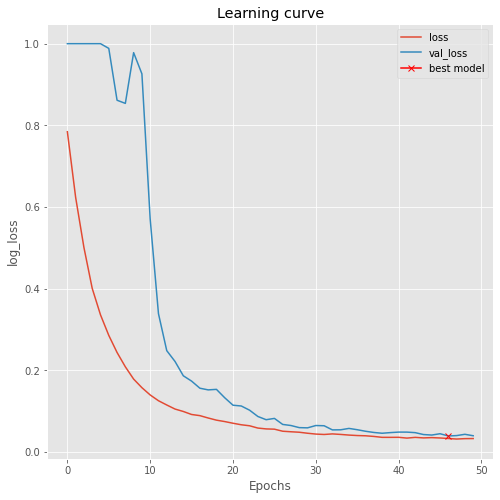

In [37]:
#plotting Learning curve ( log_loss vs epochs)
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [116]:
# load the best model
model.load_weights('baselines/model_local-tgs-salt.h5')

In [119]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_train, y_train, verbose=1)
model.evaluate(X_valid, y_valid, verbose=1)
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.3267 - accuracy: 0.9695


[0.3267362117767334, 0.9694827795028687]

In [120]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 2s 2s/step


In [1]:
#Function for viewing plots and predictions
def plot_sample(X, y, preds,text, ix=None):
    """Function to plot the results"""
    print(text) 
    
    for i in range(5) : 
        if ix is None:
            ix = random.randint(0, len(X)-1)
            
        fig, ax = plt.subplots(1, 3, figsize=(25, 15))
        ax[0].imshow(X[ix], cmap='gray')
        ax[0].set_title('Input')

        ax[1].imshow(y[ix].squeeze(),cmap='gray')
        ax[1].set_title('Mask')


        ax[2].imshow(preds[ix].squeeze(),cmap='gray')
        ax[2].set_title('Mask Predicted')
        
        d_loss = dice_loss(y[ix],preds[ix]).numpy()
        d_loss = round(d_loss*100, 3)
        
        i_loss = iou_loss(y[ix],preds[ix]).numpy()
        i_loss = round(i_loss*100, 3)
        
        text_1 = "Dice loss of image " + str(ix) +  " = " + str(d_loss) + " %"
        text_2 = "IoU loss of image " + str(ix) +  " = " + str(i_loss) + " %"
        plt.figtext(0.4, 0.2, text_1, fontsize=18)
        plt.figtext(0.4, 0.18, text_2, fontsize=18)
        
        ix = None

						Training 


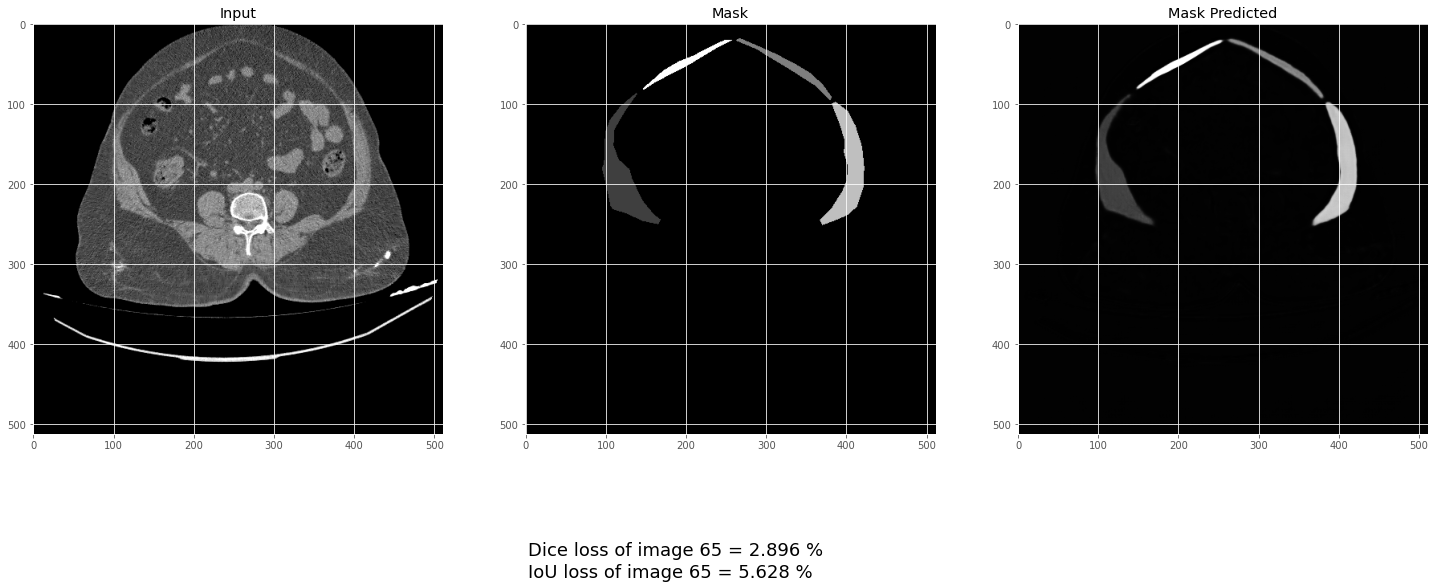

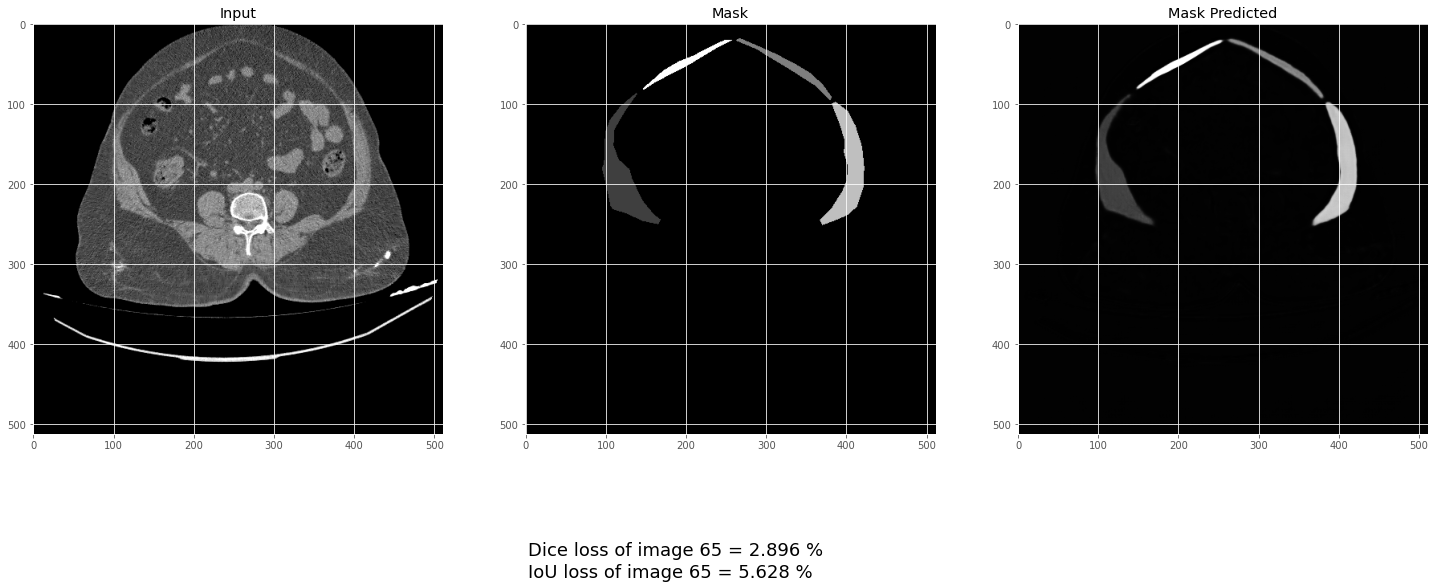

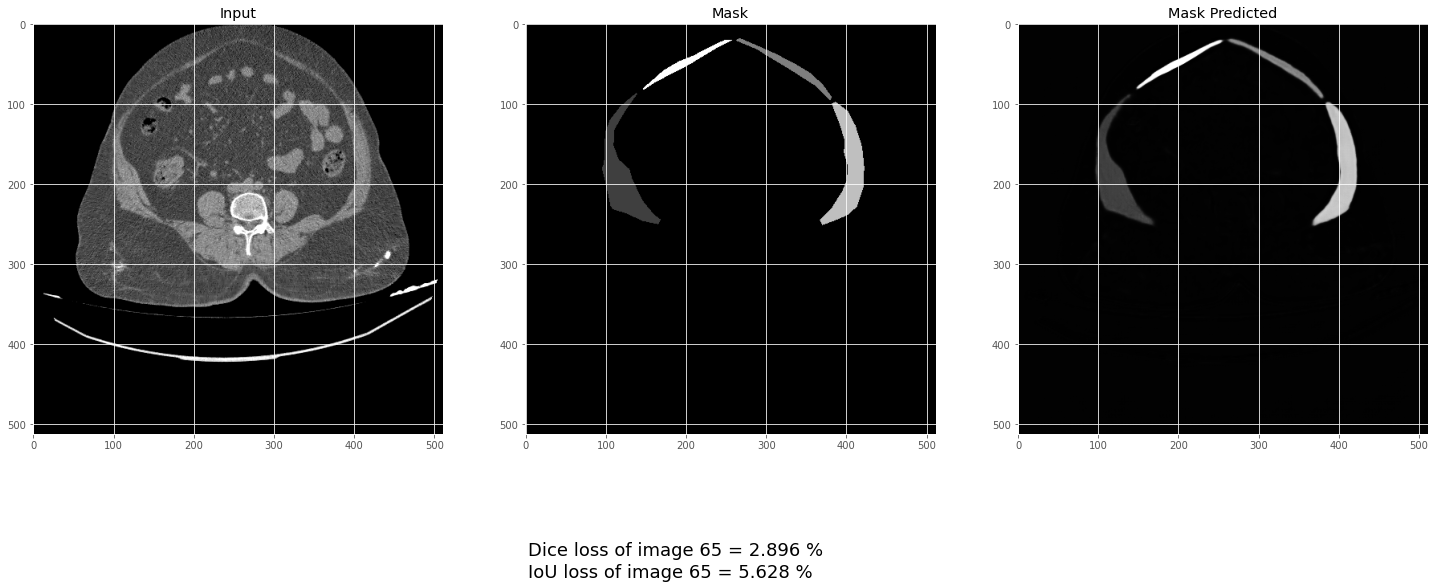

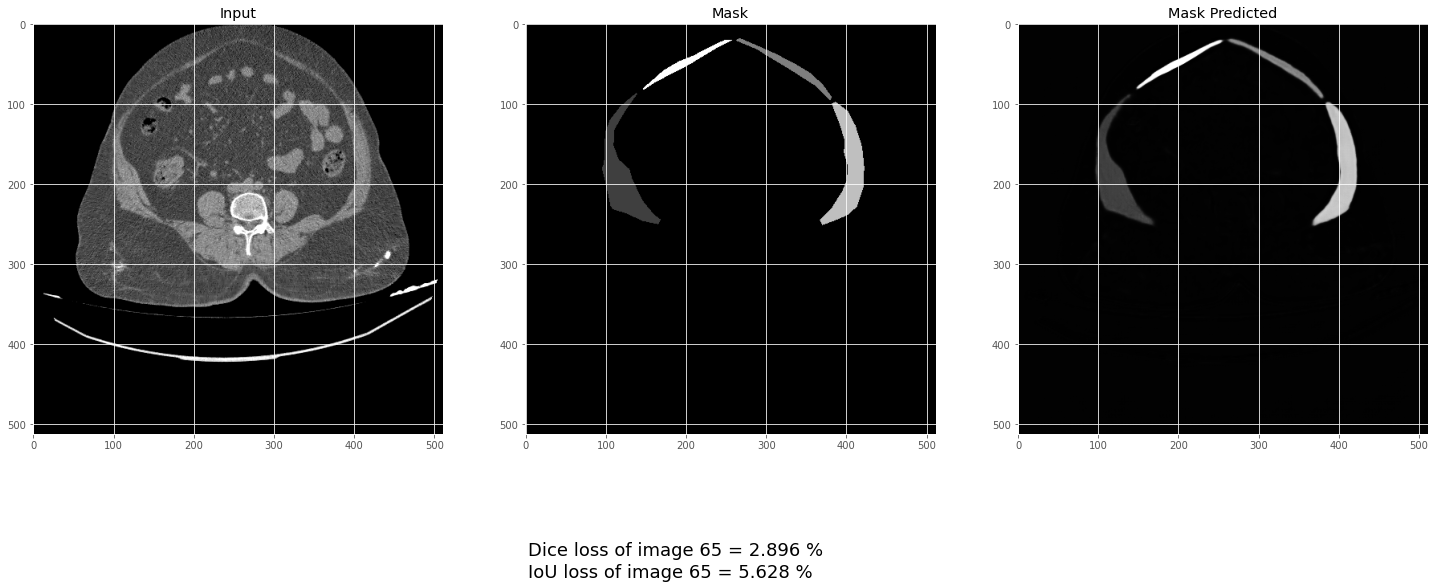

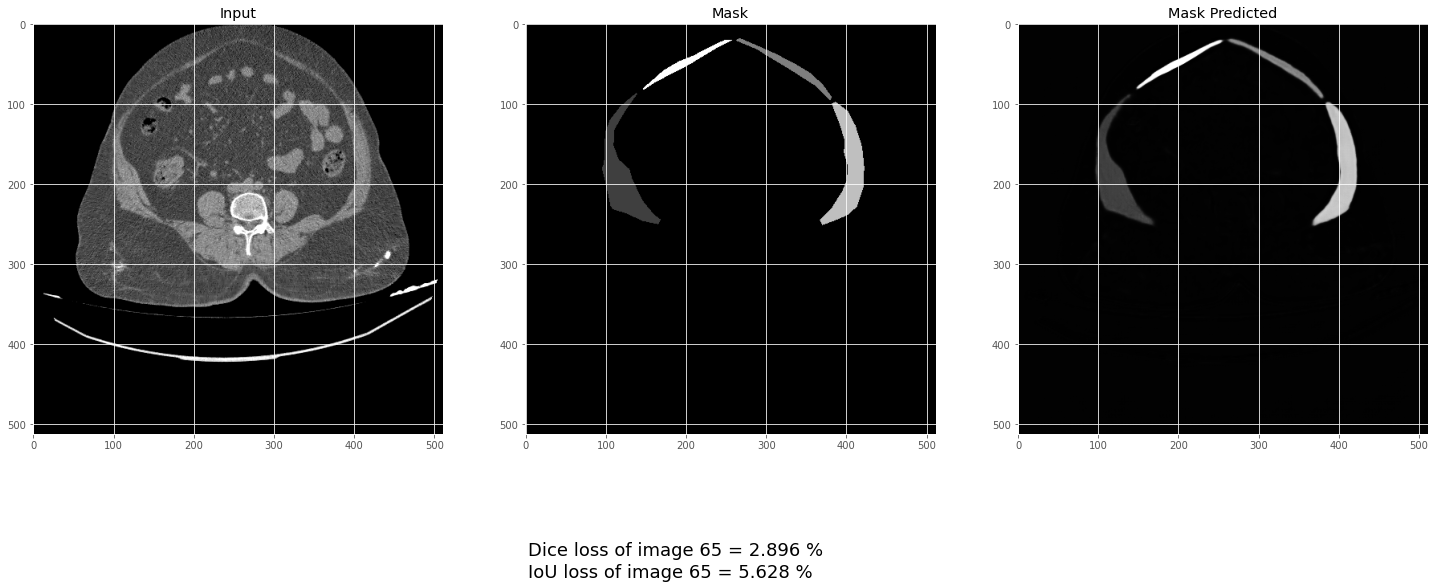

In [140]:
plot_sample(X_train, y_train, preds_train, train_text)

						Validation 


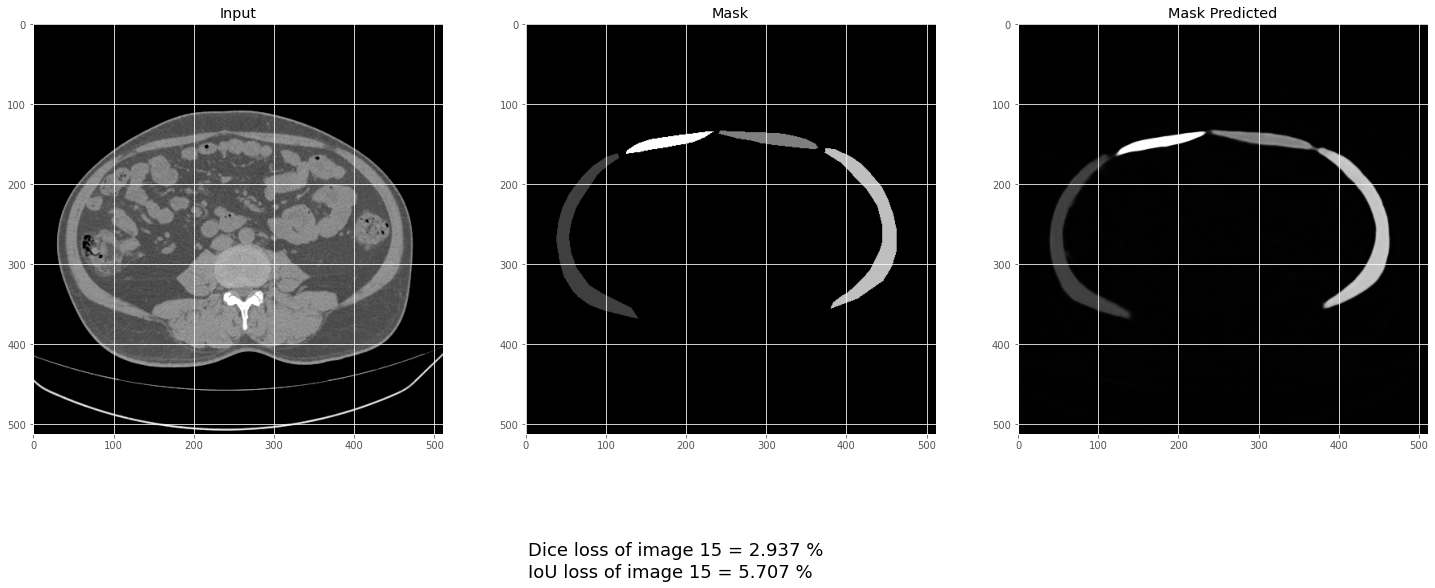

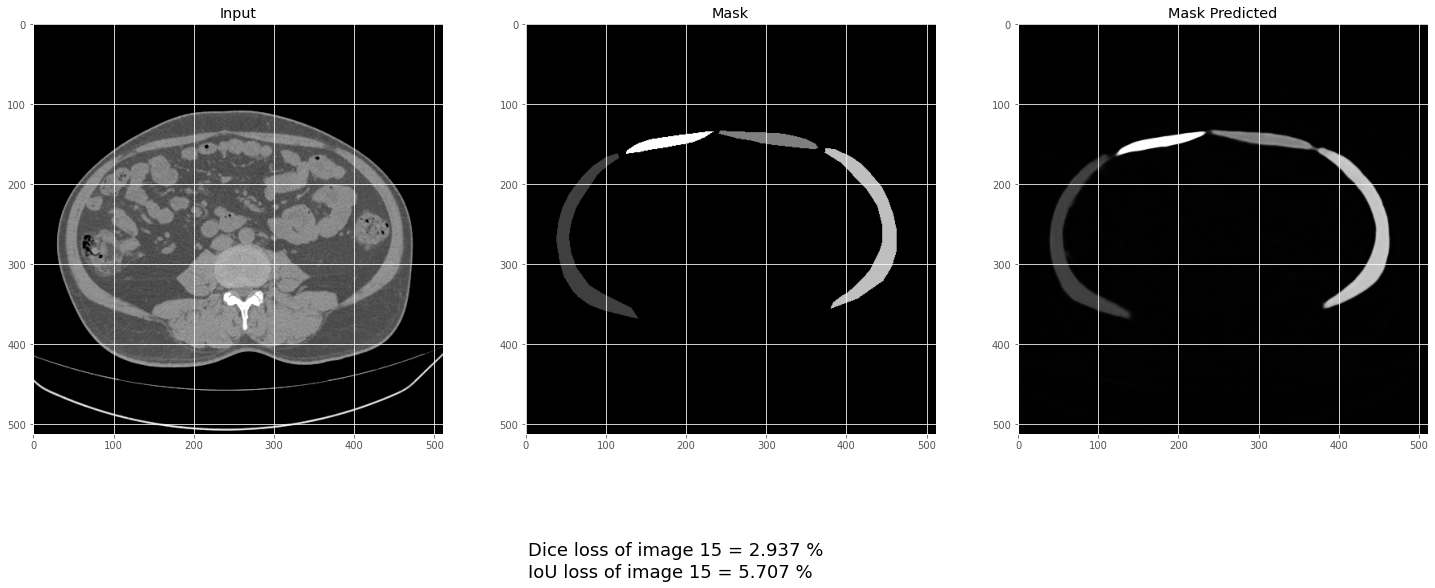

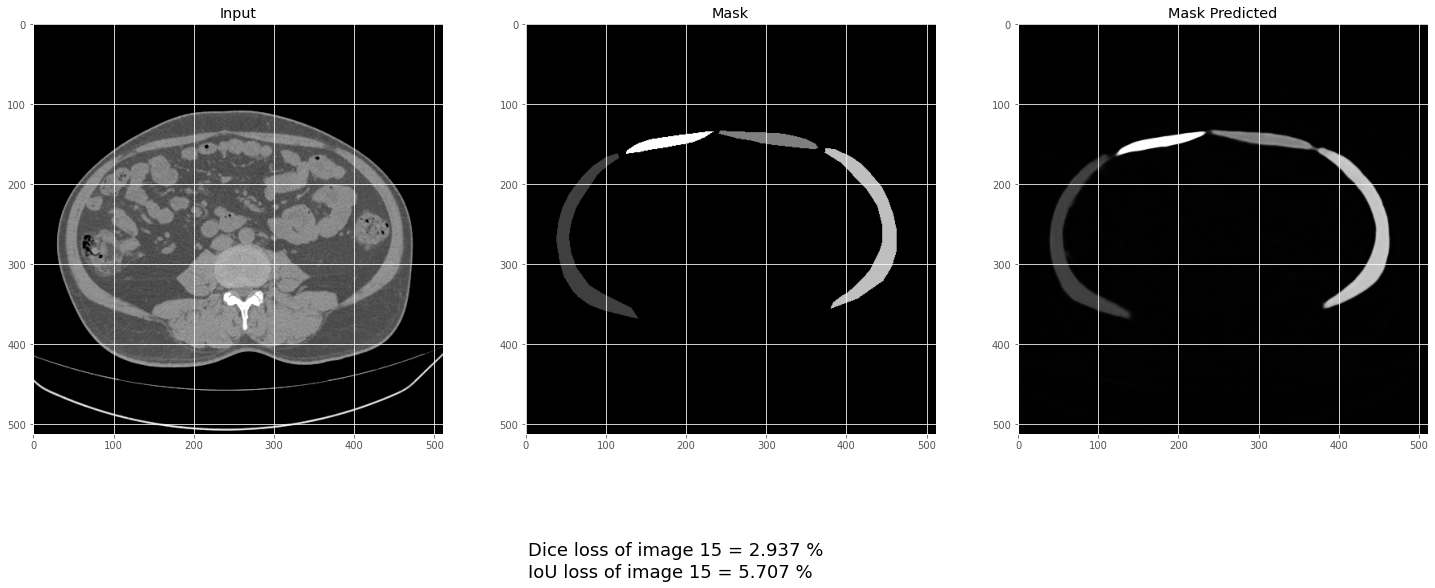

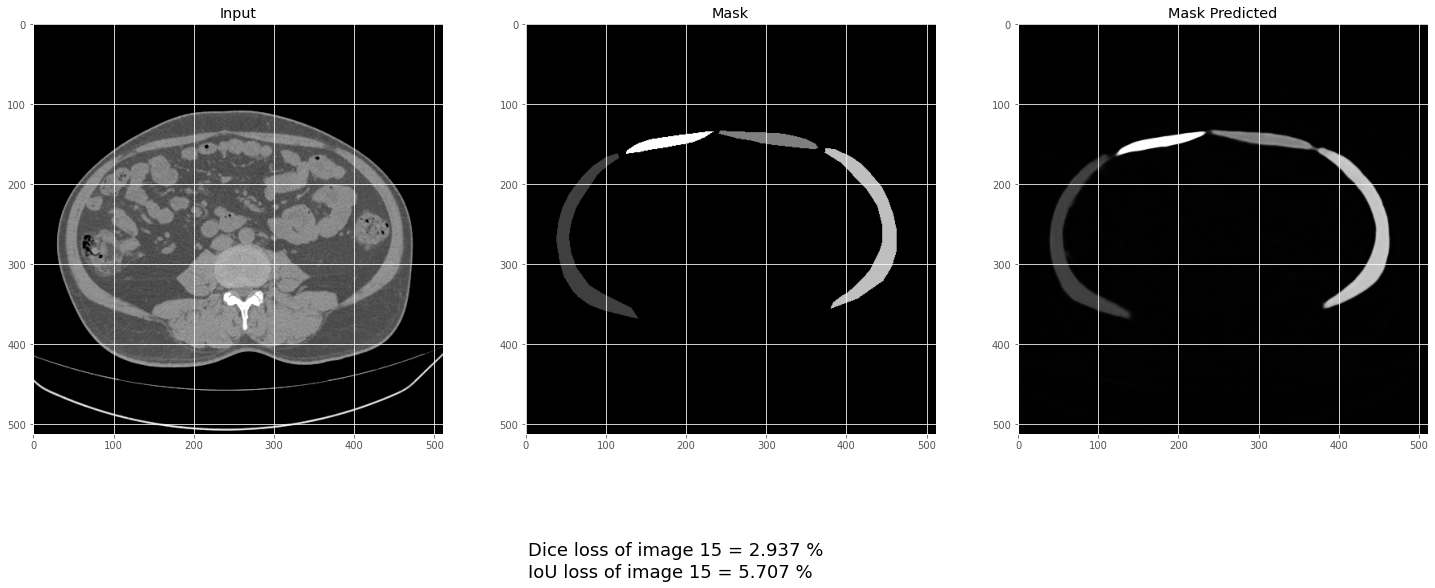

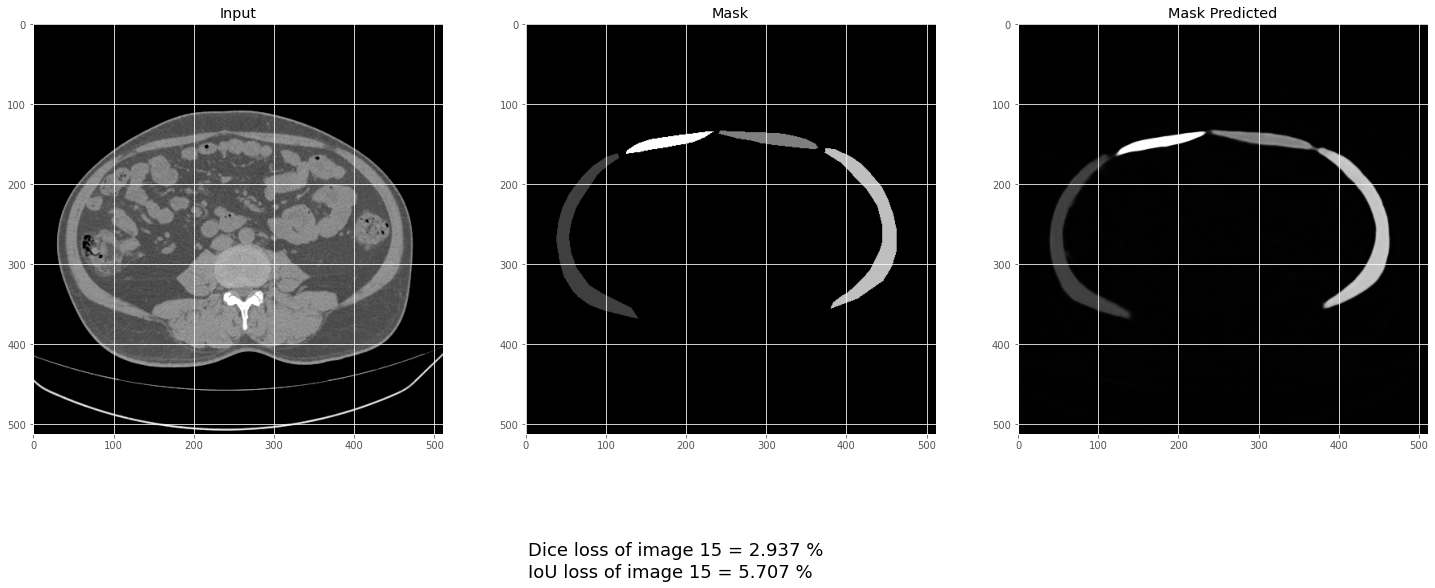

In [141]:
plot_sample(X_valid, y_valid, preds_val, valid_text)

							Testing 


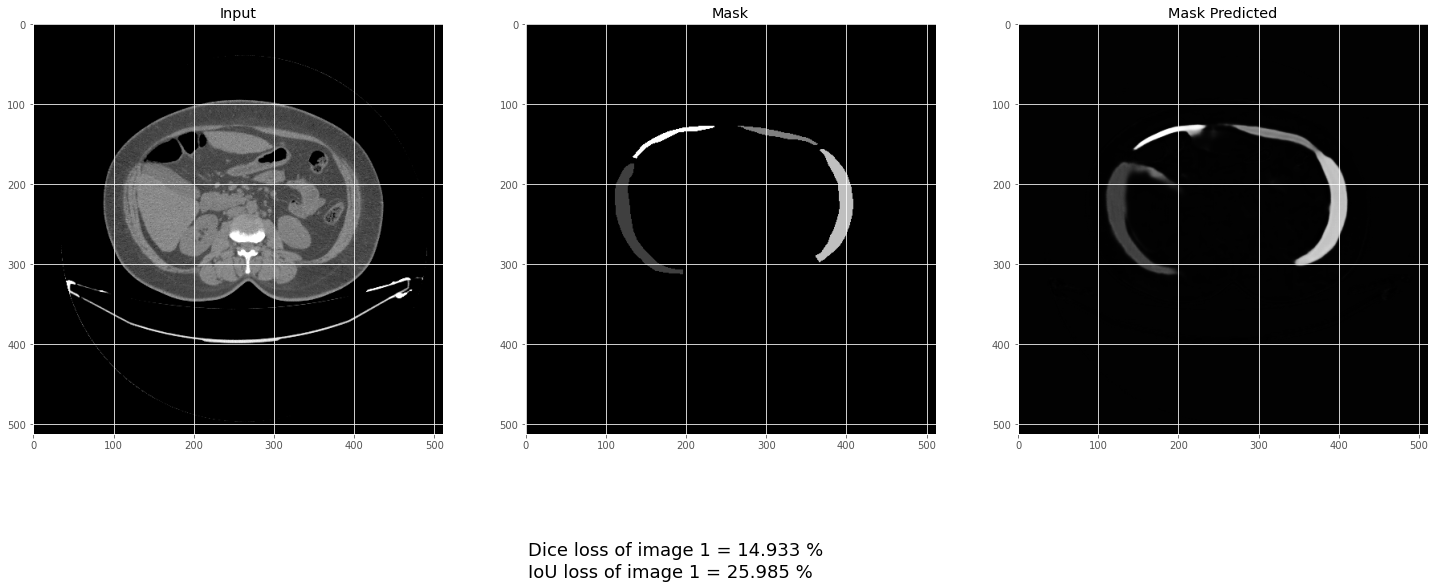

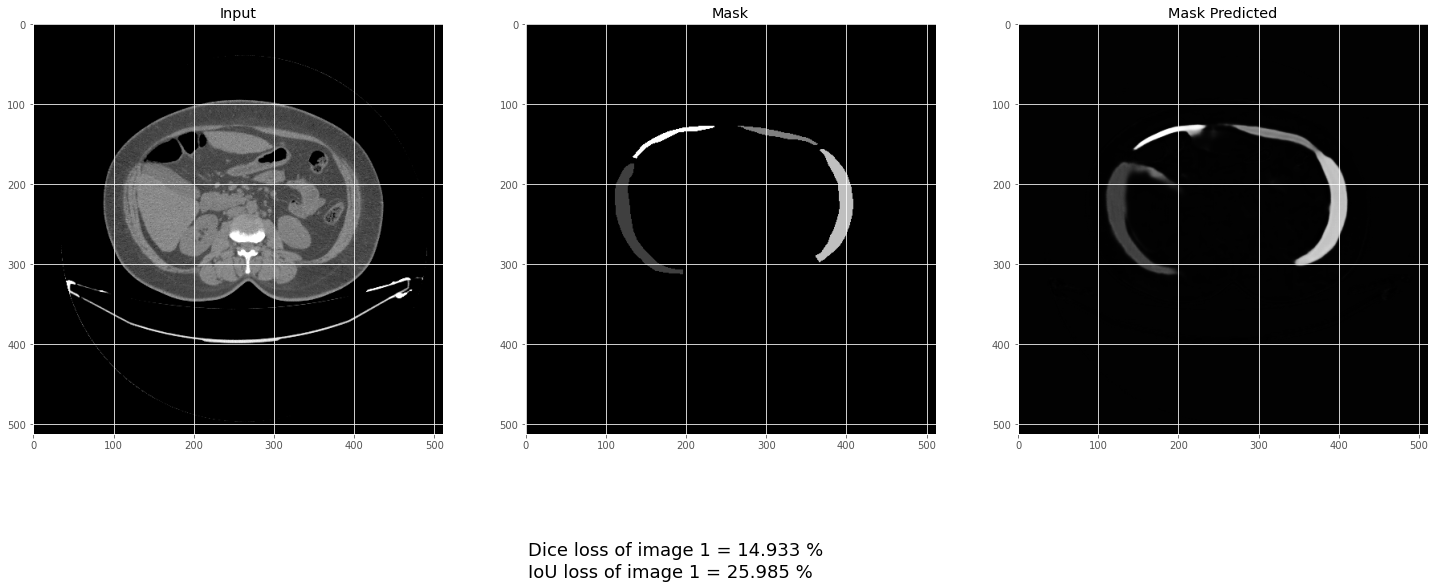

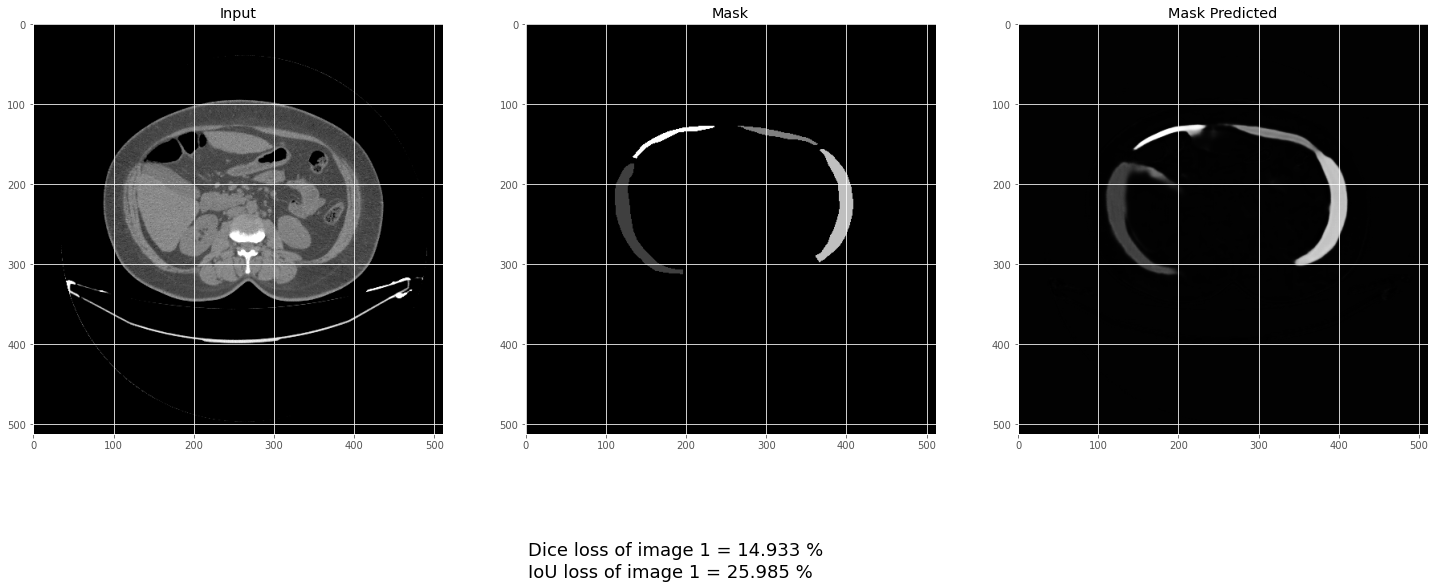

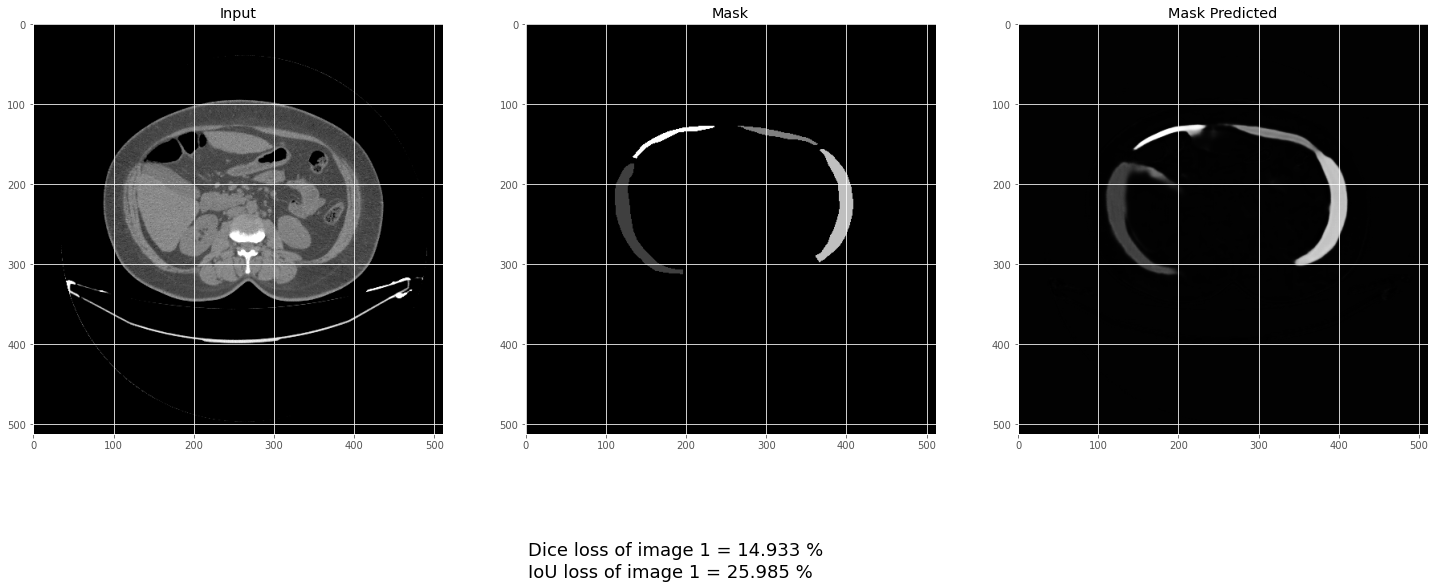

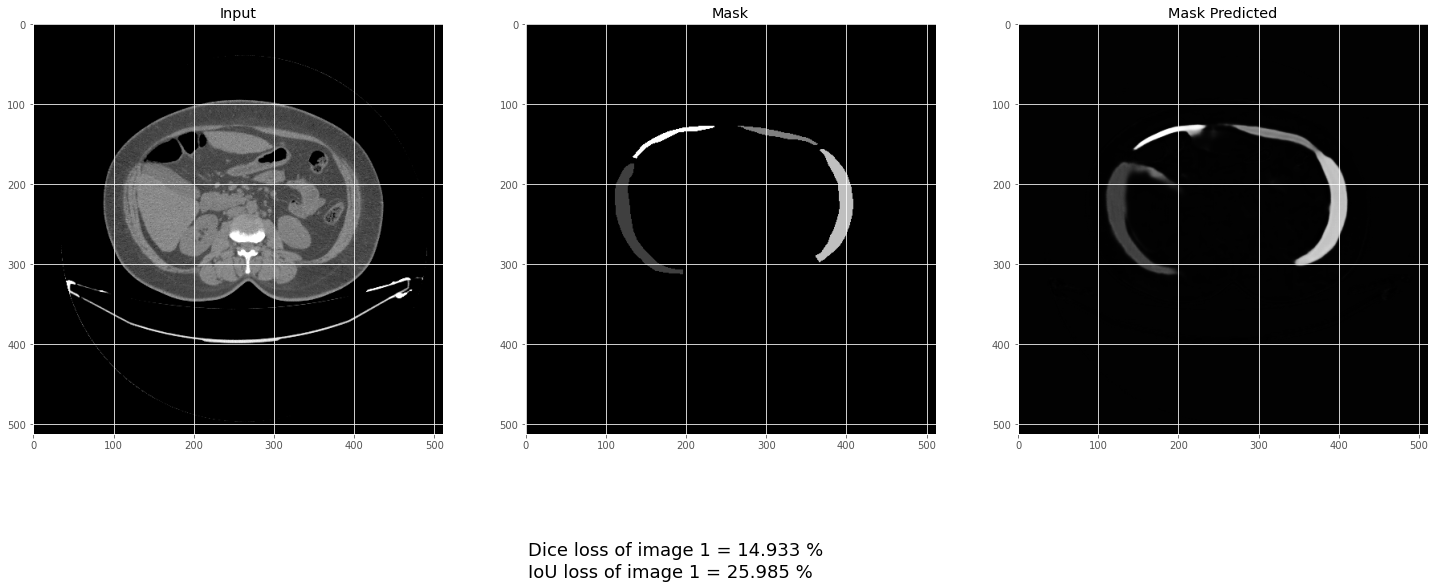

In [142]:
plot_sample(X_test, y_test, preds_test, test_text)